In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%precision %.2f
%tensorflow_version 2.x
import re
from sklearn.model_selection import train_test_split
from tensorflow.python.pywrap_tensorflow_internal import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Embedding

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Model
from keras import regularizers

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/processed_data/train_translated_cleaned.csv')
test = pd.read_csv('/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/processed_data/test_translated_cleaned.csv')
test_y = pd.read_csv("/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/processed_data/test_labels_cleaned.csv")

In [4]:
train['comment_text'] = train['comment_text'].apply(lambda x: np.str_(x))
test['comment_text'] = test['comment_text'].apply(lambda x: np.str_(x))

#split 20% of train as validation set
X = train.iloc[:,1]
y = train.iloc[:,2:]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=123)

Word Embedding
---
Use a pre-train word2vec model from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [5]:
word_vectors = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/original_data/reference_data/GoogleNews-vectors-negative300.bin.gz",binary=True)

In [6]:
# Adding list of Bad words to tokanizer
bad_words = pd.read_csv("/content/drive/MyDrive/cmpt413/project/nlpclass-1207-g-outputerror-master-project/project/original_data/reference_data/bad_words.csv")
bad_words =  list(bad_words.bad_words.values)

In [7]:
# Set Maximum number of words to be embedded
NUM_WORDS = 20000

# Define/Load Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')

# Fit the function on the text
tokenizer.fit_on_texts(X_train)

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 137136 unique tokens.


In [8]:
# Adding list of bad words to tokanizer
n = 0
temp_bw = bad_words
for word, i in word_index.items():
    if word in bad_words:
        temp_bw.remove(word)
        n = n+1
    if i > (NUM_WORDS-len(bad_words)+n):
        for bw in temp_bw:
            tokenizer.word_index[bw] = i
            i=i+1
        break    

In [9]:
# Convert train and val to sequence
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_validation = tokenizer.texts_to_sequences(X_validation)

In [10]:
# Limit size of train/val to 50 and pad the sequence
X_train = pad_sequences(sequences_train,maxlen=50)
X_validation = pad_sequences(sequences_validation,maxlen=X_train.shape[1])

# Convert target to array
y_train = np.asarray(y_train)
y_validation = np.asarray(y_validation)

# Printing shape
print('Shape of X train and X validation tensor:', X_train.shape,X_validation.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_validation.shape)


Shape of X train and X validation tensor: (127656, 50) (31915, 50)
Shape of label train and validation tensor: (127656, 6) (31915, 6)


In [11]:
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        if word in bad_words:
            vec = word_vectors['fuck']
        embedding_matrix[i]=vec

In [12]:
del(word_vectors)

In [13]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [14]:
del(embedding_matrix)

In [15]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

In [16]:
# Compiling Model using optimizer
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adam = model.fit(X_train, y_train, batch_size=400, epochs=20, verbose=2,
                      validation_data=(X_validation, y_validation),callbacks=callbacks)

Epoch 1/20
320/320 - 43s - loss: 0.1709 - val_loss: 0.0923
Epoch 2/20
320/320 - 41s - loss: 0.0845 - val_loss: 0.0761
Epoch 3/20
320/320 - 40s - loss: 0.0742 - val_loss: 0.0719
Epoch 4/20
320/320 - 40s - loss: 0.0707 - val_loss: 0.0701
Epoch 5/20
320/320 - 40s - loss: 0.0676 - val_loss: 0.0689
Epoch 6/20
320/320 - 42s - loss: 0.0660 - val_loss: 0.0676
Epoch 7/20
320/320 - 42s - loss: 0.0641 - val_loss: 0.0713


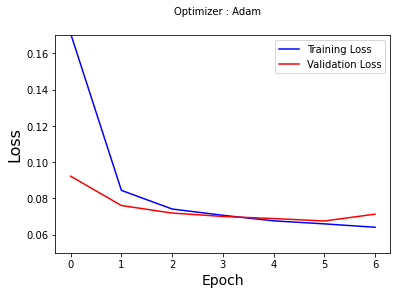

In [17]:
#plotting Loss
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylim(0.05, 0.17)
plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)
# Compiling Model using optimizer
opt = SGD(lr=0.01, momentum=0.9, decay=0.0001)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_sgd = model.fit(X_train, y_train, batch_size=600, epochs=100, verbose=2, 
                     validation_data=(X_validation, y_validation),callbacks=callbacks)

Epoch 1/100
213/213 - 12s - loss: 0.3179 - val_loss: 0.2103
Epoch 2/100
213/213 - 11s - loss: 0.1893 - val_loss: 0.1622
Epoch 3/100
213/213 - 12s - loss: 0.1527 - val_loss: 0.1353
Epoch 4/100
213/213 - 12s - loss: 0.1335 - val_loss: 0.1222
Epoch 5/100
213/213 - 12s - loss: 0.1238 - val_loss: 0.1149
Epoch 6/100
213/213 - 12s - loss: 0.1180 - val_loss: 0.1102
Epoch 7/100
213/213 - 12s - loss: 0.1139 - val_loss: 0.1069
Epoch 8/100
213/213 - 12s - loss: 0.1112 - val_loss: 0.1043
Epoch 9/100
213/213 - 12s - loss: 0.1086 - val_loss: 0.1021
Epoch 10/100
213/213 - 12s - loss: 0.1063 - val_loss: 0.1002
Epoch 11/100
213/213 - 12s - loss: 0.1051 - val_loss: 0.0987
Epoch 12/100
213/213 - 12s - loss: 0.1035 - val_loss: 0.0974
Epoch 13/100
213/213 - 12s - loss: 0.1023 - val_loss: 0.0963
Epoch 14/100
213/213 - 12s - loss: 0.1012 - val_loss: 0.0953
Epoch 15/100
213/213 - 12s - loss: 0.1002 - val_loss: 0.0944
Epoch 16/100
213/213 - 12s - loss: 0.0992 - val_loss: 0.0936
Epoch 17/100
213/213 - 12s - loss

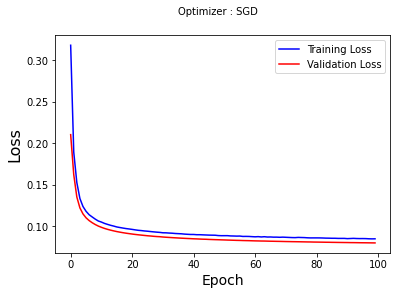

In [ ]:
#plotting Loss
plt.suptitle('Optimizer : SGD', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
#plt.ylim(0.05, 0.17)
plt.plot(hist_sgd.history['loss'], color='b', label='Training Loss')
plt.plot(hist_sgd.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
# this creates a model that includes
model = Model(inputs, output)
# Compiling Model using optimizer
opt = Adadelta(lr=0.01)
model.compile(loss='binary_crossentropy',optimizer=opt)
# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adad = model.fit(X_train, y_train, batch_size=400, epochs=100, verbose=2, 
                      validation_data=(X_validation, y_validation),callbacks=callbacks)

Epoch 1/50
320/320 - 11s - loss: 0.8078 - val_loss: 0.7818
Epoch 2/50
320/320 - 11s - loss: 0.7567 - val_loss: 0.7305
Epoch 3/50
320/320 - 11s - loss: 0.7062 - val_loss: 0.6803
Epoch 4/50
320/320 - 11s - loss: 0.6570 - val_loss: 0.6316
Epoch 5/50
320/320 - 11s - loss: 0.6095 - val_loss: 0.5844
Epoch 6/50
320/320 - 11s - loss: 0.5640 - val_loss: 0.5397
Epoch 7/50
320/320 - 11s - loss: 0.5220 - val_loss: 0.4991
Epoch 8/50
320/320 - 11s - loss: 0.4843 - val_loss: 0.4634
Epoch 9/50
320/320 - 11s - loss: 0.4520 - val_loss: 0.4333
Epoch 10/50
320/320 - 11s - loss: 0.4249 - val_loss: 0.4086
Epoch 11/50
320/320 - 11s - loss: 0.4029 - val_loss: 0.3887
Epoch 12/50
320/320 - 11s - loss: 0.3853 - val_loss: 0.3727
Epoch 13/50
320/320 - 11s - loss: 0.3709 - val_loss: 0.3600
Epoch 14/50
320/320 - 11s - loss: 0.3596 - val_loss: 0.3497
Epoch 15/50
320/320 - 11s - loss: 0.3505 - val_loss: 0.3414
Epoch 16/50
320/320 - 11s - loss: 0.3430 - val_loss: 0.3344
Epoch 17/50
320/320 - 11s - loss: 0.3367 - val_lo

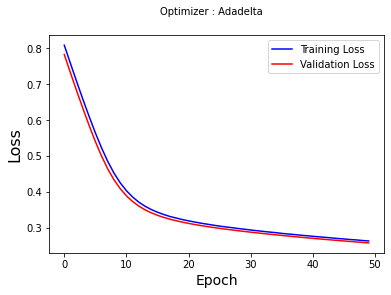

In [ ]:
#plotting Loss
plt.suptitle('Optimizer : Adadelta', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
#plt.ylim(0.05, 0.17)
plt.plot(hist_adad.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adad.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

Predict on Test set
---

In [38]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

In [39]:
# Compiling Model using optimizer
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
model.fit(X_train, y_train, batch_size=400, epochs=20, verbose=2,
                      validation_data=(X_validation, y_validation),callbacks=callbacks)

Epoch 1/20
320/320 - 45s - loss: 0.1209 - val_loss: 0.0848
Epoch 2/20
320/320 - 42s - loss: 0.0649 - val_loss: 0.0741
Epoch 3/20
320/320 - 43s - loss: 0.0592 - val_loss: 0.0708
Epoch 4/20
320/320 - 41s - loss: 0.0576 - val_loss: 0.0703
Epoch 5/20
320/320 - 40s - loss: 0.0565 - val_loss: 0.0712


In [40]:
# convert test to sequence and padding the sequence
sequences_test=tokenizer.texts_to_sequences(test['comment_text'])
X_test = pad_sequences(sequences_test,maxlen=X_train.shape[1])

# Predict on train, val and test datasets
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
pred_val = model.predict(X_validation)

In [41]:
#convert probabilities to labels with threshold 0.75
for j in range(0,6):
    temp = pred_train[:,j]
    for i in range(0,len(temp)):
        if temp[i] > 0.75:
            pred_train[:,j][i] = 1
        else: 
            pred_train[:,j][i] = 0
    
for j in range(0,6):
    temp = pred_test[:,j]
    for i in range(0,len(temp)):
        if temp[i] > 0.75:
            pred_test[:,j][i] = 1
        else: 
            pred_test[:,j][i] = 0
            
for j in range(0,6):
    temp = pred_val[:,j]
    for i in range(0,len(temp)):
        if temp[i] > 0.75:
            pred_val[:,j][i] = 1
        else: 
            pred_val[:,j][i] = 0

In [42]:
from sklearn import metrics
# Creating empty prediction array
col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
Accuracy = np.zeros((3,6))
for i,x in enumerate(col):
    acc = np.array([metrics.accuracy_score(y_train[:,i], pred_train[:,i]),
                    metrics.accuracy_score(y_validation[:,i], pred_val[:,i]),
                    metrics.accuracy_score(test_y[x], pred_test[:,i])])
    print(x,"Train Accuracy:",acc[0],", Val Accuracy:",acc[1],", Test Accuracy:",acc[2])
    Accuracy[:,i] = acc
    
avg_accuracy = Accuracy.mean(axis=1)
print("Average Train Accuracy:",avg_accuracy[0],
      ", Average Val Accuracy:",avg_accuracy[1],
      ", Average Test Accuracy:",avg_accuracy[2])

toxic Train Accuracy: 0.9630334649370182 , Val Accuracy: 0.9561334795550681 , Test Accuracy: 0.9303979492950701
severe_toxic Train Accuracy: 0.9902237262643354 , Val Accuracy: 0.9903806987310042 , Test Accuracy: 0.9942323923848823
obscene Train Accuracy: 0.9791000814689478 , Val Accuracy: 0.973022089926367 , Test Accuracy: 0.9643314889493263
threat Train Accuracy: 0.996937080904932 , Val Accuracy: 0.9972113426288579 , Test Accuracy: 0.9966707305636312
insult Train Accuracy: 0.9730760794635583 , Val Accuracy: 0.9679147736174213 , Test Accuracy: 0.9599080934071087
identity_hate Train Accuracy: 0.9911637525850724 , Val Accuracy: 0.9912580291399029 , Test Accuracy: 0.9887930226015192
Average Train Accuracy: 0.9822556976039775 , Average Val Accuracy: 0.9793200689331036 , Average Test Accuracy: 0.9723889462002563
